In [1]:
import numpy as np 
import FlowCytometryTools
from FlowCytometryTools import FCMeasurement
from FlowCytometryTools import FCPlate
from FlowCytometryTools import ThresholdGate, PolyGate
import matplotlib.pyplot as plt
import scipy as sp
import scipy.special
import seaborn as sns
import pandas as pd
import datetime as dt

FSCHgateupper = ThresholdGate(6050.0, ['FSC-H'], region='below')
FSCHgatelower = ThresholdGate(5000.0, ['FSC-H'], region='above')
SSCHgatelower = ThresholdGate(4600.0, ['SSC-H'], region='above') 
SSCHgateupper = ThresholdGate(5800.0, ['SSC-H'], region='below')
scatter_gates = FSCHgateupper & FSCHgatelower & SSCHgatelower & SSCHgateupper


datadir = '/Volumes/WD Elements/8.18.22_abundance/'
plate = FCPlate.from_dir(ID='96-well', path=datadir, parser='name')
plate_transformed = plate.transform('hlog', channels=['RFP-H','YFP-H'], b=100.0).transform('hlog', channels=['FSC-H','SSC-H'], b=10.0**2)#.gate(scatter_gates)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/FlowCytometryTools/core/transforms.py:180: RuntimeWarning: divide by zero encountered in log10
  lxmin = max([log10(abs(xmin)), 0])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/FlowCytometryTools/core/transforms.py:180: RuntimeWarning: divide by zero encountered in log10
  lxmin = max([log10(abs(xmin)), 0])


In [26]:
rfp_threshold = {"A1": 6600, "B1":6600, "C1":6500, "D1":6500, "E1":6500, "F1": 6500, "G1":6500, "H1":6500,
                "A3":6500, "B3":6500, "C3":6500, "D3":6500, "E3":6500, "F3":6500, "G3":6500, "H3":6500,
                "A5":6500, "B5":6500, "C5":6500, "D5":6500, "E5":6500, "F5":6500, "G5":6500, "H5":6500,
                "A7":6500, "B7":6500, "C7":6500, "D7":6500, "E7":6500, "F7":6500, "G7":6500, "H7":6500,
                "A9":6500, "B9":6500, "C9":6500, "D9":6500, "E9":6500, "F9":6500, "G9":6500, "H9":6500,
                "A11":6500, "B11":6500, "C11":6500, "D11":6500, "E11":6500, "F11":6500, "G11":6500, "H11":6500}
rfp_threshold_real = 6900
yfp_threshold = 6500

def plot_plates(well, rfp_threshold, yfp_threshold):
    r_gate = ThresholdGate(rfp_threshold_real, ['RFP-H'], region='above')
    y_gate = ThresholdGate(yfp_threshold, ['YFP-H'], region='above')
    
    plt.figure()
    plt.title(well)
    plate_transformed[well].plot(['RFP-H'], gates=[r_gate])
    plt.show()

    plt.figure()
    plate_transformed[well].plot(['RFP-H','YFP-H'], gates=[r_gate, y_gate])
    plt.show()

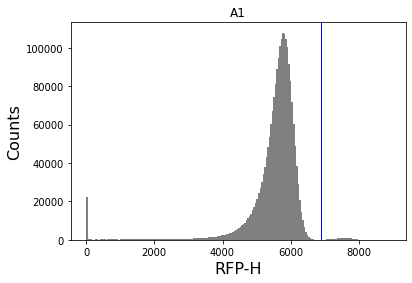

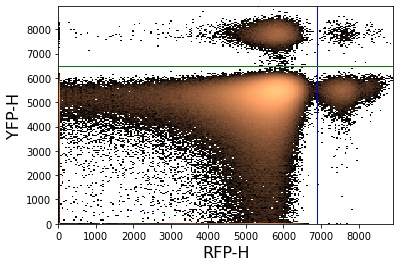

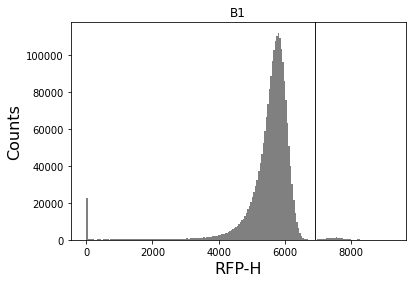

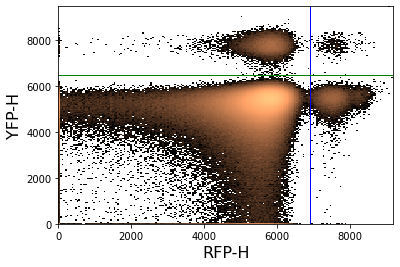

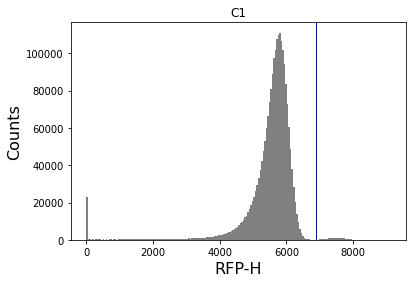

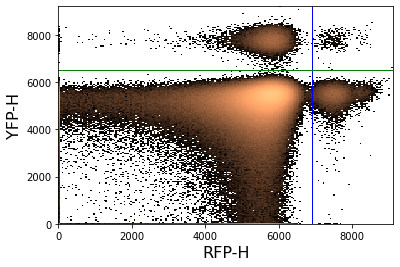

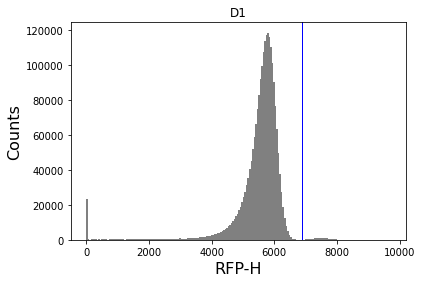

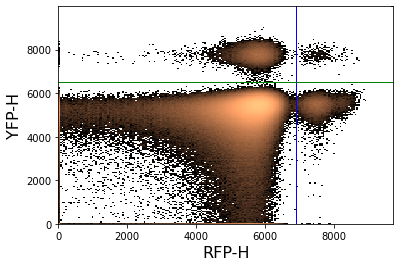

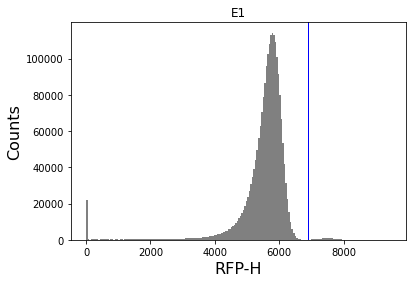

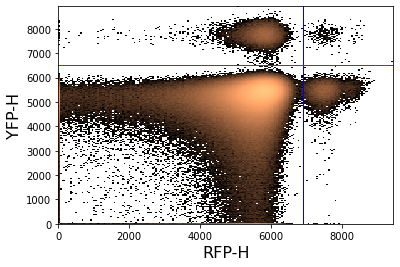

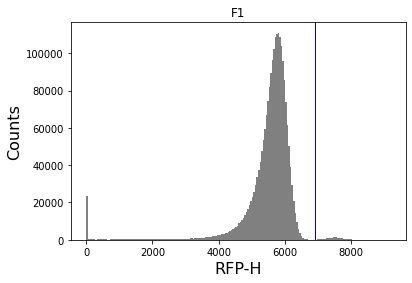

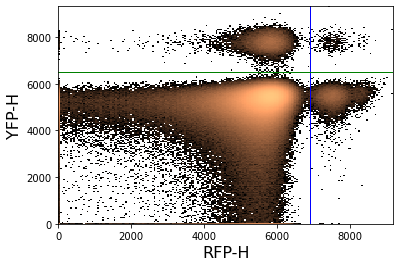

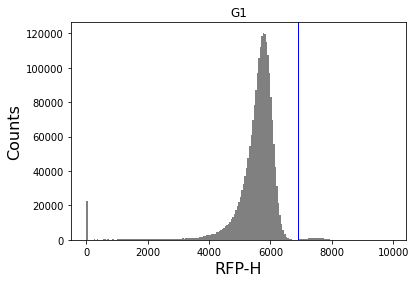

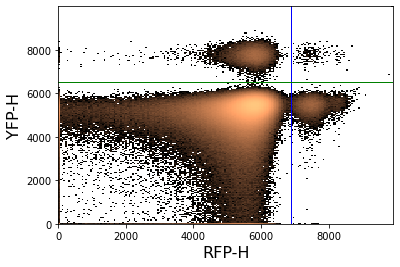

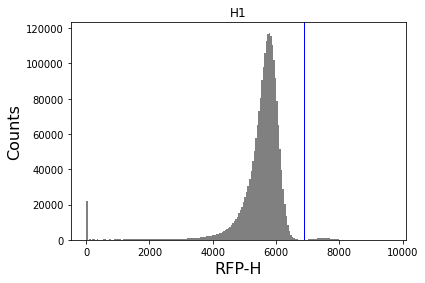

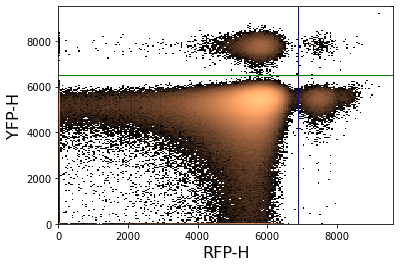

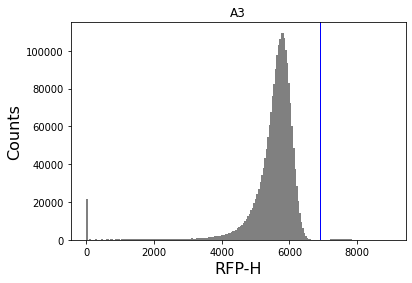

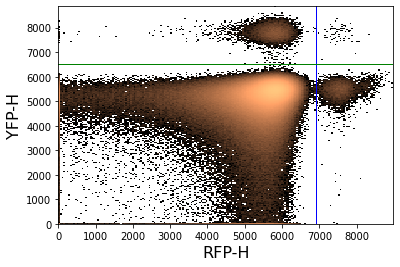

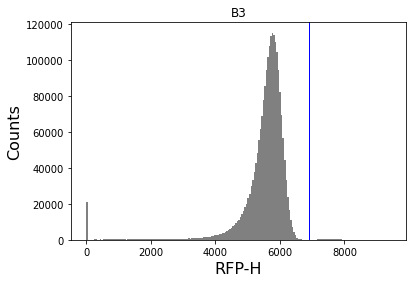

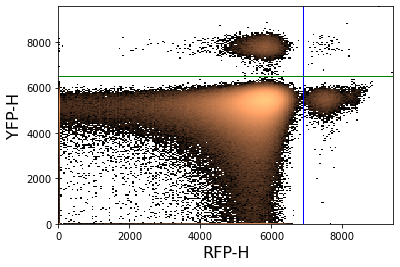

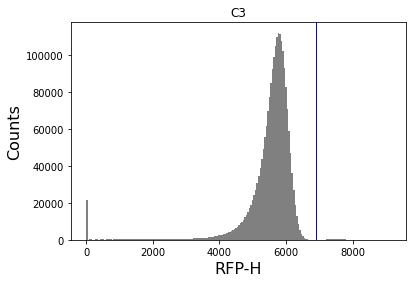

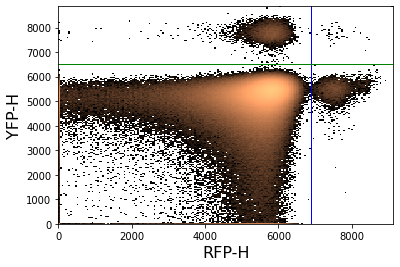

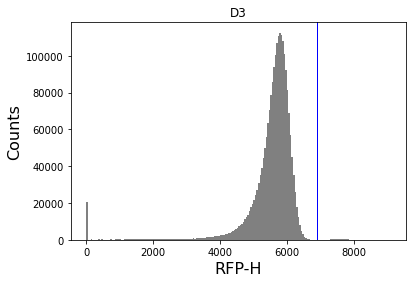

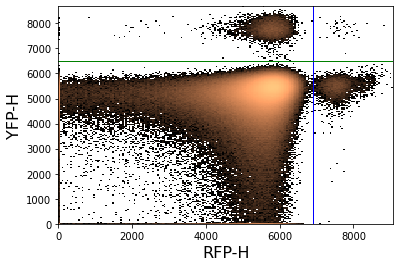

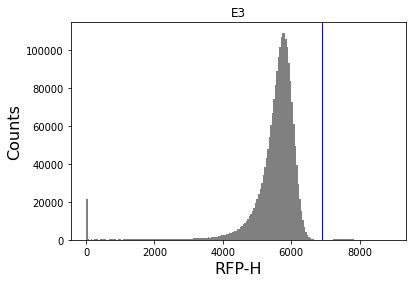

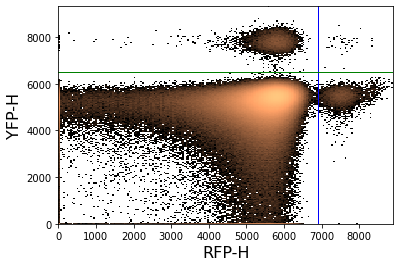

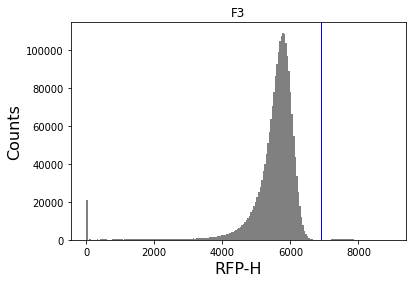

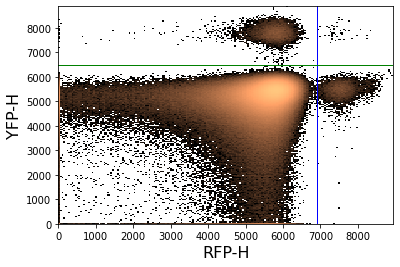

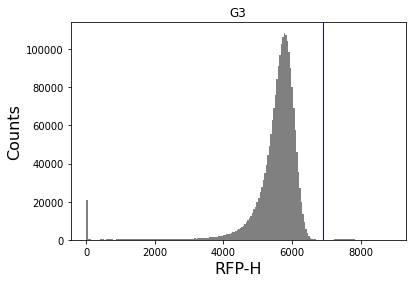

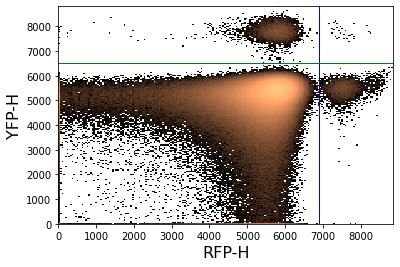

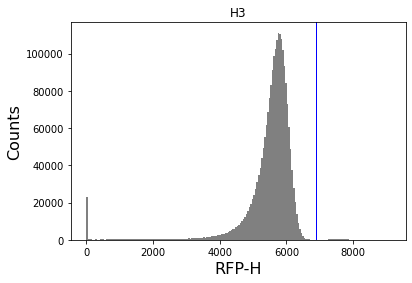

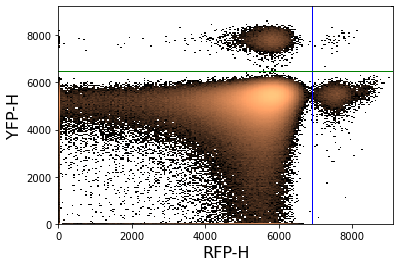

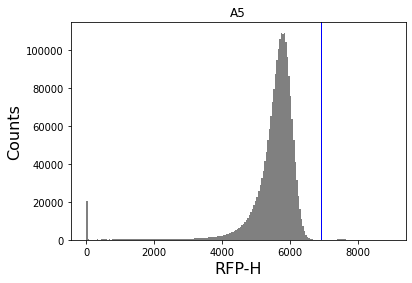

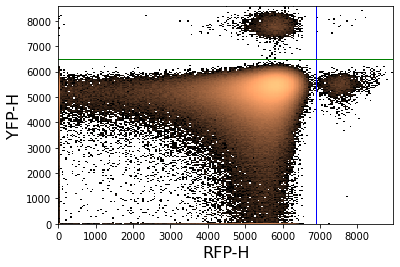

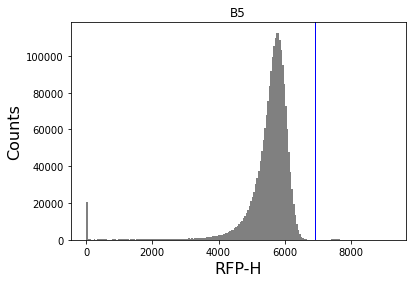

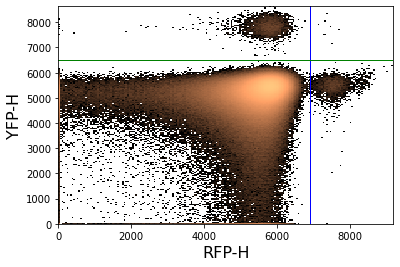

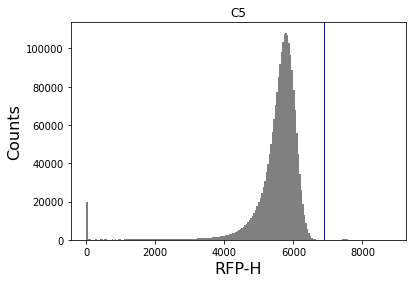

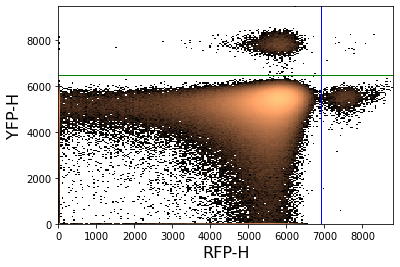

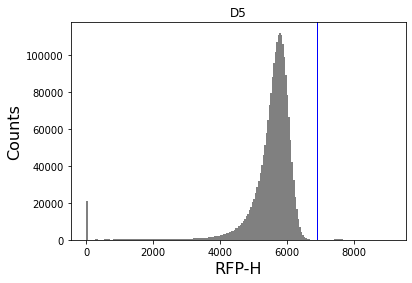

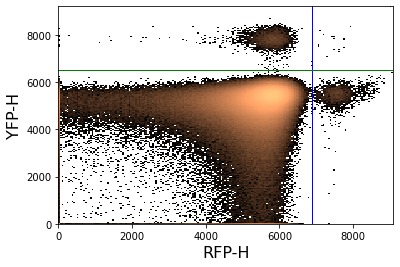

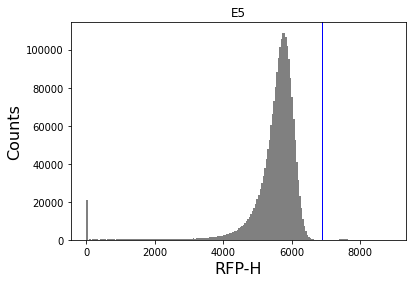

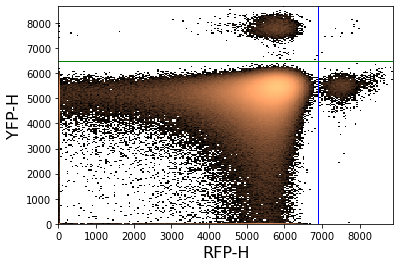

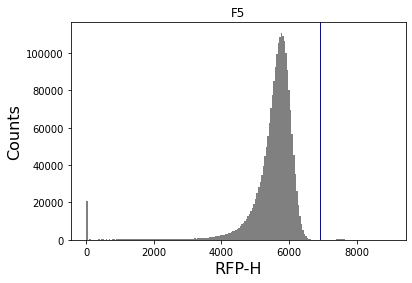

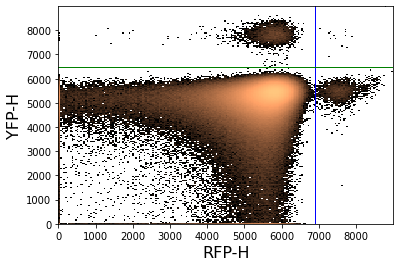

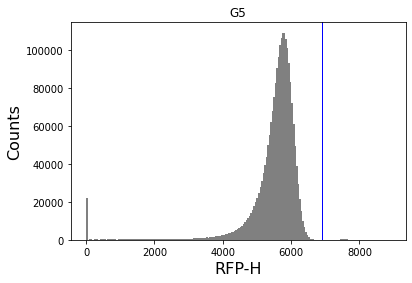

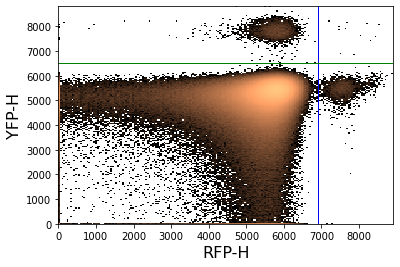

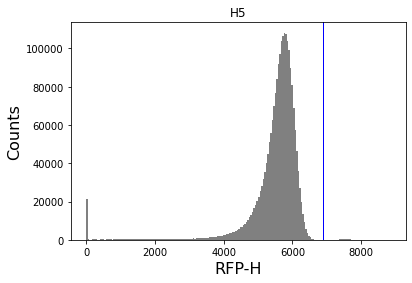

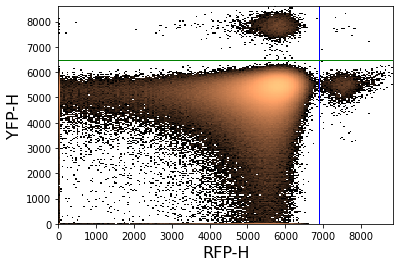

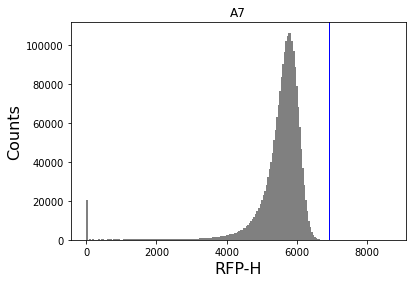

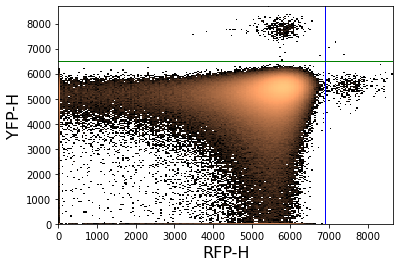

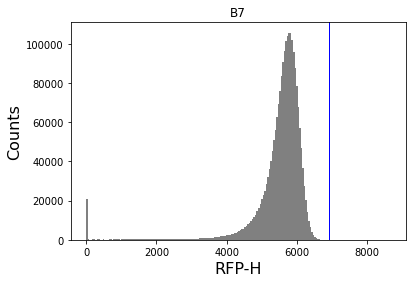

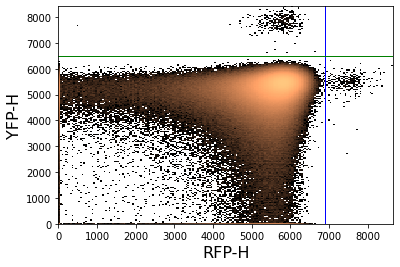

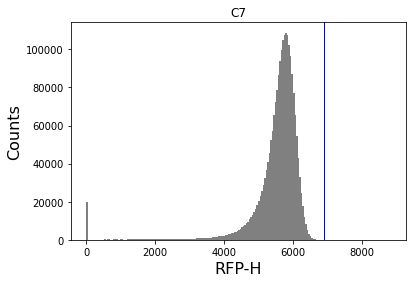

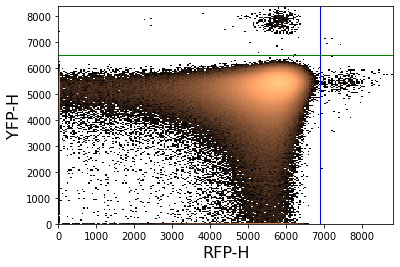

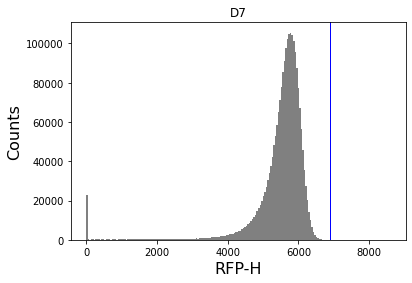

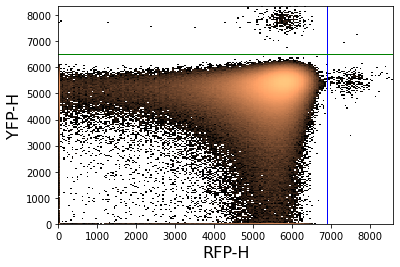

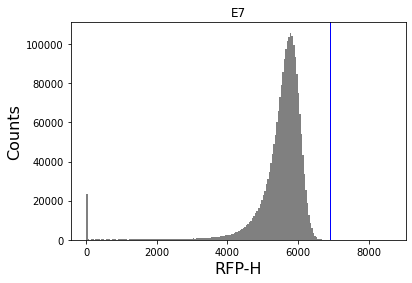

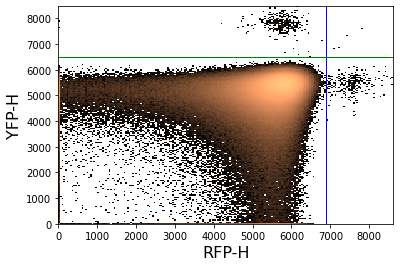

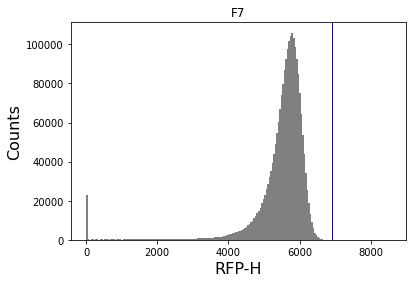

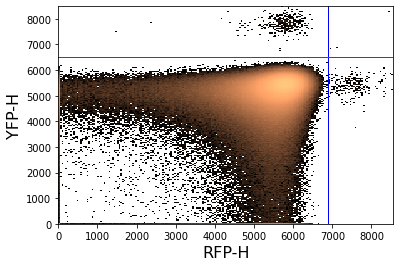

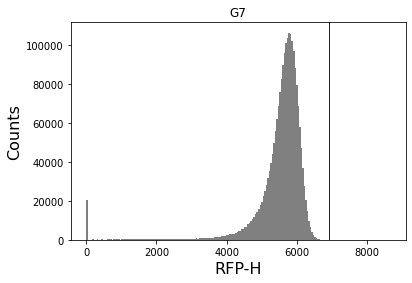

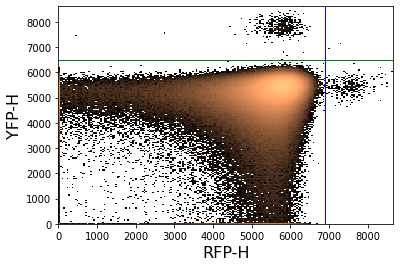

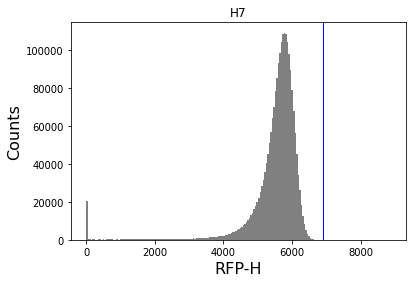

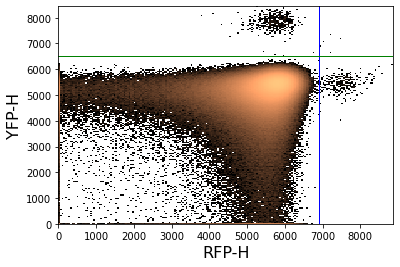

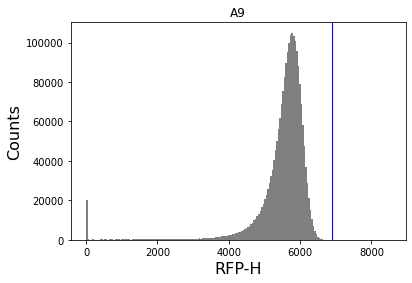

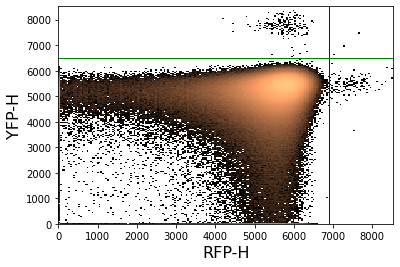

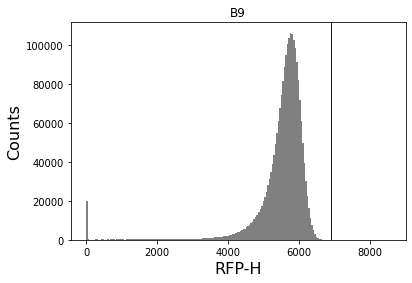

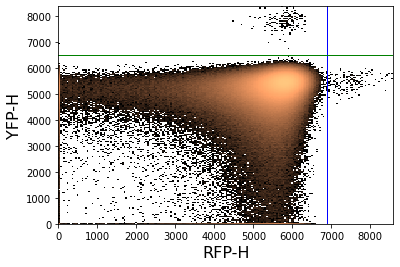

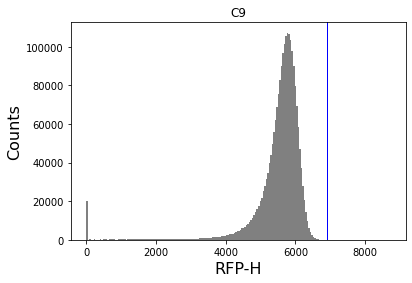

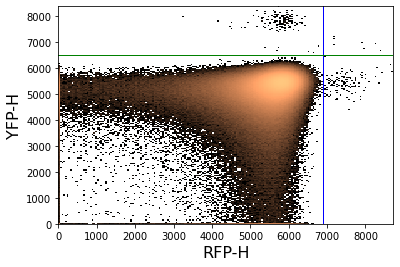

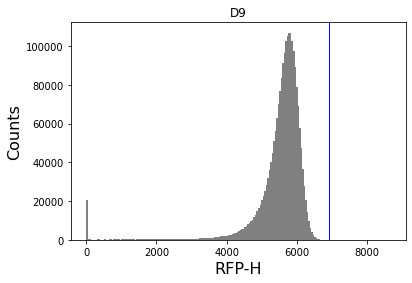

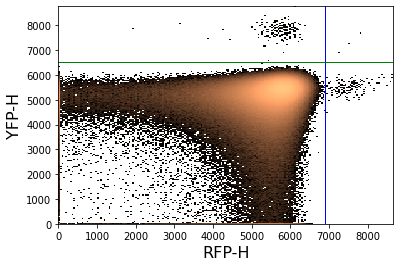

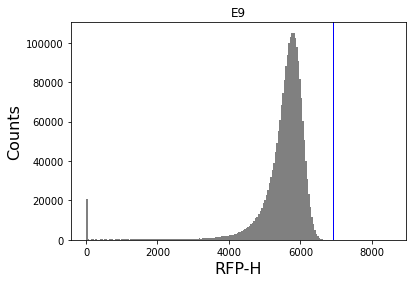

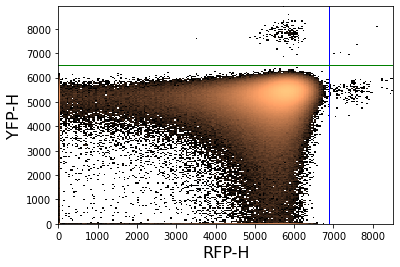

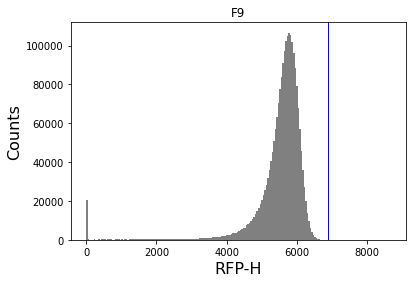

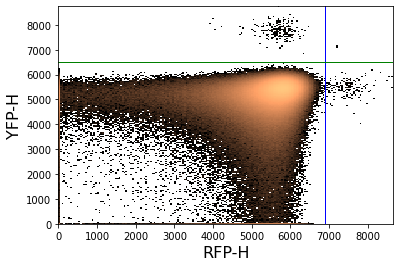

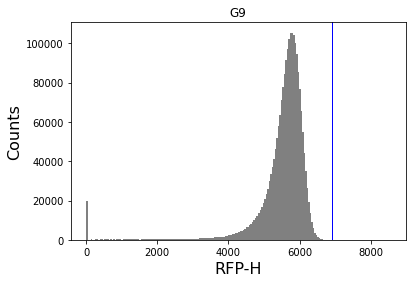

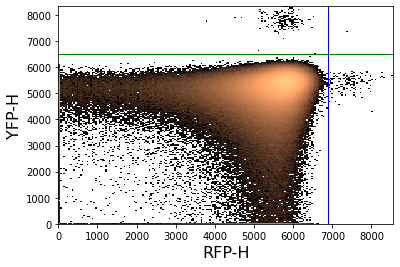

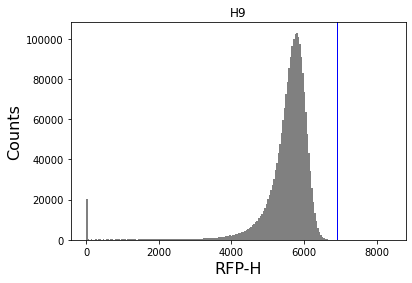

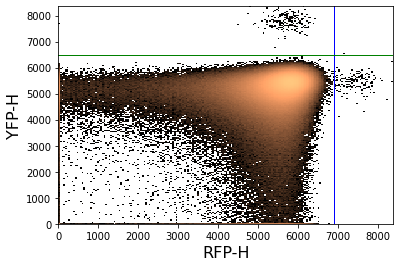

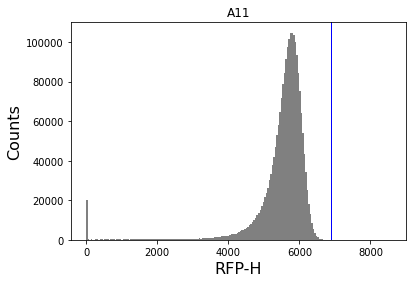

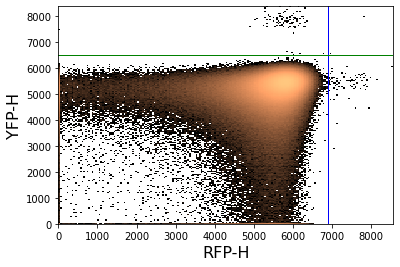

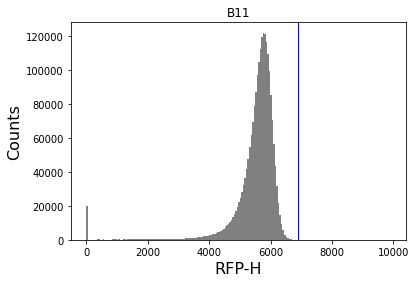

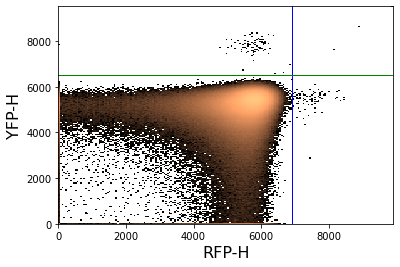

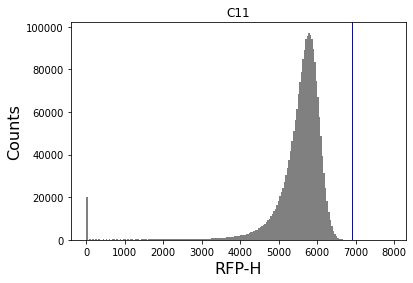

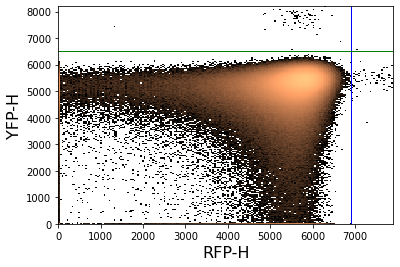

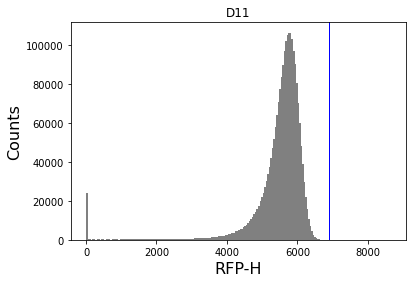

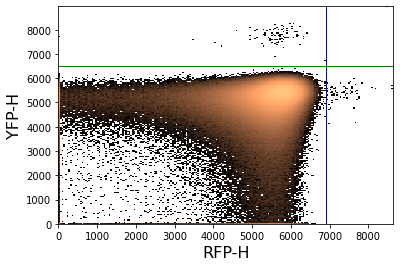

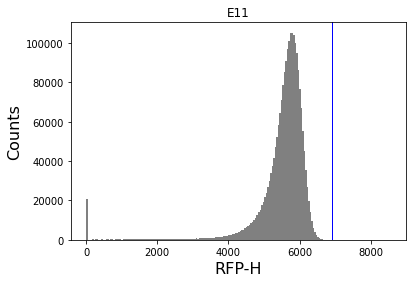

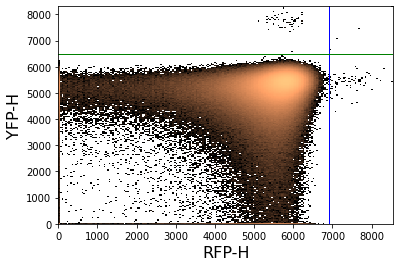

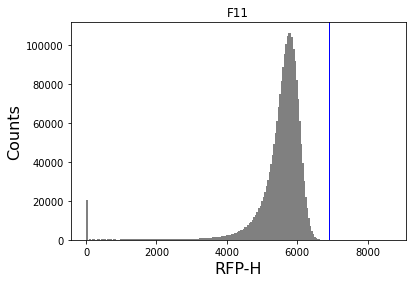

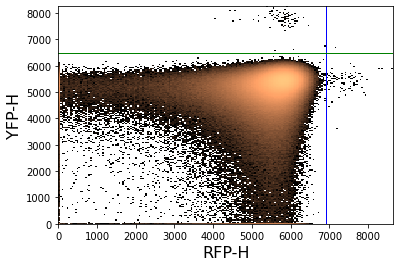

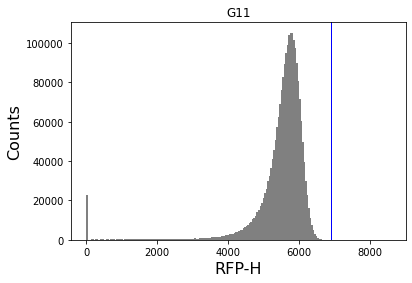

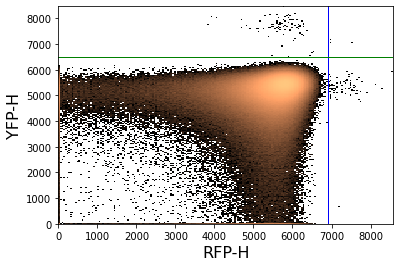

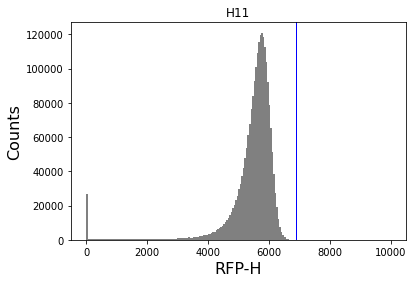

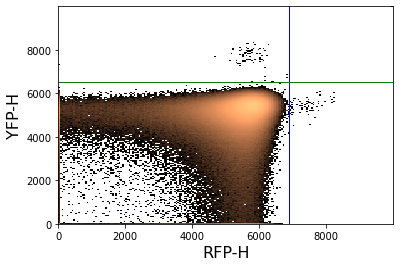

In [27]:
for well in rfp_threshold.keys():
    plot_plates(well, rfp_threshold, yfp_threshold)

In [28]:
def f1_expectation(theta,f1obs_data,f2obs_data,nmax=100):
    f1,lam = theta
    f2=1-f1
    f1obs=0
    f2obs=0
    for k in range(1,nmax):
        f1obs+=((f1*lam)**k)/scipy.special.factorial(k)/(np.exp(lam)-1)
        f2obs+=((f2*lam)**k)/scipy.special.factorial(k)/(np.exp(lam)-1)
    return f1obs-f1obs_data, f2obs-f2obs_data


def get_rfp_freq(data, well):
    rfp_pos = data['RFP-H']>rfp_threshold_real
    yfp_pos = data['YFP-H']>yfp_threshold
    rfp_neg = data['RFP-H']<rfp_threshold_real
    yfp_neg = data['YFP-H']<yfp_threshold

    rfp = len(data[rfp_pos & yfp_neg])
    yfp = len(data[yfp_pos & rfp_neg])
    dp = len(data[rfp_pos & yfp_pos])
    Q = rfp + yfp + dp
    func = lambda theta: f1_expectation(theta,rfp/Q,yfp/Q)
    res = sp.optimize.root(func, [rfp/Q, 0.5])
    rfp_count = rfp
    
    return res.x, Q, rfp_count

In [29]:
b_data=[]

cols = [1,3,5,7,9,11]
rows = ['A','B','C','D','E','F','G','H']


for row in rows:
    for col in cols:
            well = row + str(col)
            well_sort = str(col) + row
            try:
                res,Q,rfp = get_rfp_freq(plate_transformed[well].data, well)
            except:
                continue
            if col == 1:
                group = "dil 1:2"
            if col == 3:
                group = "dil 1:5"
            if col == 5:
                group = "dil 1:10"
            if col == 7:
                group = "dil 1:100"
            if col == 9:
                group = "dil 1:200"
            if col == 11:
                group = "dil 1:500"
            b_data.append({
                #'day':day,
                #'plate':plates[day].index(plate)+1,
                'well':well,
                'sort by well': well_sort,
                'group': group,
                'R freq': res[0],
                'lambda': res[1],
                'total count':Q,
                'corrected total count': Q*res[1]/(1-np.exp(-res[1])),
                'RFP count':rfp,
            })     
            
df = pd.DataFrame(b_data)
df['f_trafo'] = np.arcsin(2*df['R freq'] - 1) #perform variance stabilizing transform
df.sort_values(['sort by well'])

,well,sort by well,group,R freq,lambda,total count,corrected total count,RFP count,f_trafo
5,A11,11A,dil 1:500,0.463539,4.189094e-02,192,196.049607,88,-0.072987
11,B11,11B,dil 1:500,0.539480,6.355946e-02,190,196.102108,101,0.079043
17,C11,11C,dil 1:500,0.516667,2.669673e-02,150,152.011163,77,0.033340
23,D11,11D,dil 1:500,0.463067,2.285220e-02,176,178.018653,81,-0.073933
29,E11,11E,dil 1:500,0.604223,1.161894e-01,144,152.527598,85,0.209985
35,F11,11F,dil 1:500,0.517143,2.288429e-02,175,177.010013,90,0.034293
41,G11,11G,dil 1:500,0.479881,6.908422e-02,174,180.079524,82,-0.040249
47,H11,11H,dil 1:500,0.463815,2.645473e-02,152,154.019424,70,-0.072434
0,A1,1A,dil 1:2,0.406527,4.324627e-02,36901,37704.666304,14809,-0.188053
6,B1,1B,dil 1:2,0.402888,3.814322e-02,42721,43540.937720,17016,-0.195467


In [30]:
df_var = df.groupby(['group']).var().rename(columns = {'f_trafo':'var(f_trafo)'}).sort_values(['total count'], ascending=False) #calculate variance
df_var.head(50)

,R freq,lambda,total count,corrected total count,RFP count,var(f_trafo)
group,,,,,,
dil 1:2,0.000011,0.000019,1.643789e+07,1.709547e+07,2.740686e+06,0.000047
dil 1:5,0.000015,0.000004,1.666369e+06,1.717836e+06,3.161542e+05,0.000062
dil 1:10,0.000030,0.000003,7.294029e+04,7.109921e+04,1.576514e+04,0.000126
dil 1:100,0.000520,0.000079,3.878268e+03,4.047029e+03,5.652679e+02,0.002143
dil 1:200,0.000937,0.000893,9.064107e+02,8.016084e+02,2.994286e+02,0.003796
dil 1:500,0.002445,0.001079,3.364107e+02,3.394112e+02,8.564286e+01,0.009873


In [39]:
df_mean = df.groupby(['group']).mean().sort_values(['total count'], ascending=False)
df_mean['dilution'] = [0.5, 0.2, 0.1, 0.01, 0.005, 0.002]
df_mean.head(50)

,R freq,lambda,total count,corrected total count,RFP count,f_trafo
group,,,,,,
dil 1:2,0.404519,0.035343,38637.750,39325.228202,15468.750,-0.192147
dil 1:5,0.403136,0.013393,14414.375,14511.972747,5790.750,-0.194966
dil 1:10,0.399481,0.008139,6763.000,6790.406277,2695.500,-0.202429
dil 1:100,0.421710,0.016569,737.375,743.565568,308.875,-0.157382
dil 1:200,0.449634,0.032116,360.125,365.742464,160.500,-0.101072
dil 1:500,0.505977,0.048701,169.125,173.227261,84.250,0.012132


In [41]:
df_mean['conc'] = df_mean['corrected total count']/(df_mean['dilution']*0.02)
df_mean.head(50)

,R freq,lambda,total count,corrected total count,RFP count,f_trafo,dilution,conc
group,,,,,,,,
dil 1:2,0.404519,0.035343,38637.750,39325.228202,15468.750,-0.192147,0.500,3.932523e+06
dil 1:5,0.403136,0.013393,14414.375,14511.972747,5790.750,-0.194966,0.200,3.627993e+06
dil 1:10,0.399481,0.008139,6763.000,6790.406277,2695.500,-0.202429,0.100,3.395203e+06
dil 1:100,0.421710,0.016569,737.375,743.565568,308.875,-0.157382,0.010,3.717828e+06
dil 1:200,0.449634,0.032116,360.125,365.742464,160.500,-0.101072,0.005,3.657425e+06
dil 1:500,0.505977,0.048701,169.125,173.227261,84.250,0.012132,0.002,4.330682e+06


In [23]:
dil_abun = df_mean['RFP count']/df_mean['corrected total count']
print(dil_abun)

group
dil 1:2      0.394434
dil 1:5      0.400126
dil 1:10     0.398678
dil 1:100    0.423843
dil 1:200    0.452709
dil 1:500    0.513890
dtype: float64


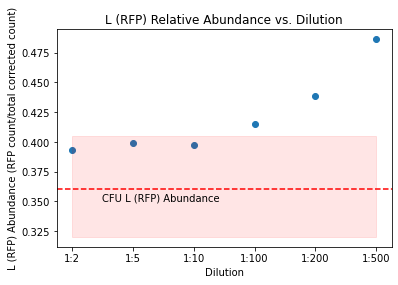

In [33]:
#cfu 
#Plate 1:
#S: 78; L: 46; total = 124*0^5 = 1.24E7

#Plate 2:
#S: 99; L: 53; total = 152*0^5 = 1.52E7

#mean(L(RFP)) = 49.5
#var(count) = 1.8*mean(count)
#mean(count) = 138
#var(count) = 1.8*138 = 248.4
#std = sqrt(var) = 15.76
#lower_std = 138+15.76=153.76 --> 49.5/153.76 = 0.32
#upper_std = 138-15.76=122.24 --> 49.5/122.24 = 0.405

#abundance of L: 46/124 = 0.37; 53/152 = 0.35 --> mean abundnace of L: 0.36
dilution = ['1:2', '1:5', '1:10', '1:100', '1:200', '1:500']  
dil_abun = df_mean['RFP count']/df_mean['corrected total count']
plt.scatter(dilution, dil_abun)
plt.title("L (RFP) Relative Abundance vs. Dilution")
plt.xlabel("Dilution")
plt.ylabel("L (RFP) Abundance (RFP count/total corrected count)")
plt.axhline(y=0.36, color='r', linestyle='--')
plt.text(0.5, 0.35, 'CFU L (RFP) Abundance')
plt.fill_between(dilution, 0.32, 0.405, color='r', alpha=0.1)
plt.show()



In [26]:
def CI(alpha, df_var):
    n = 8
    a = sp.stats.chi2.isf(1-alpha/2, n-1)
    b = sp.stats.chi2.isf(alpha/2, n-1)
    df_var['u'] = ((n-1)*df_var['var(f_trafo)'])/a - df_var['var(f_trafo)']
    df_var['l'] = df_var['var(f_trafo)'] - ((n-1)*df_var['var(f_trafo)'])/b

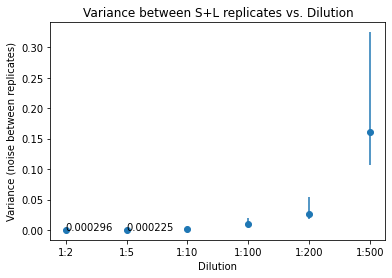

In [28]:
CI(0.32, df_var)
dilution = ['1:2', '1:5', '1:10', '1:100', '1:200', '1:500']  
labels = ['0.000296', '0.000225']

dilution_var = df_var['var(f_trafo)']
plt.scatter(dilution, dilution_var)
plt.errorbar(dilution, dilution_var,   
             yerr = (df_var['l'].to_list(),df_var['u'].to_list()), fmt='none')

plt.title("Variance between S+L replicates vs. Dilution")
plt.xlabel("Dilution")
plt.ylabel("Variance (noise between replicates)")
for dil, var, label in zip(dilution, dilution_var, labels):
    plt.text(dil, var, label)

plt.show()